# Guide communication série avec Python :

--------------

##### Sommaire :

$\quad \quad $ I- Introduction et objectifs

$\quad \quad $ II- Communication série avec `PySerial`

$\quad \quad \quad \quad \quad$ II-a. Lister les appareils connectés

$\quad \quad \quad \quad \quad$ II-b. Établir la communication avec l'appareil

$\quad \quad \quad \quad \quad$ II-c. Première communication

$\quad \quad \quad \quad \quad$ II-d. Récupérer et afficher des données - exemple avec un capteur de température

$\quad \quad $ III- Conclusion


----------

## I- Introduction et objectifs :

Ce Jupyter Notebook constitue un résumé du chapitre 3 *Writing the first Driver* du guide *Python for lab the Lab.*

Il se concentrera sur la communication avec les appareils série avec le package `Pyserial`, l'envoi et la réception de données ainsi que sur les notions "basiques" orbitant autour avec à chaque étape des exemples et des codes Python.

Nous utiliserons les packages `PySerial`, `time` et `Matplotlib`, le package `PyVisa` sera cité en exemple à la conclusion.

## II- Communication série avec `PySerial` :

### II.a- Lister les appareils connectés :

Pour communiquer avec les appareils *PFTL DAQ*, nous allons utiliser le package `PySerial`.


In [1]:
import serial

En premier lieu, nous allons lister les appareils connectés à notre ordinateur. Il est d'usage de connecter l'appareil au port USB le plus proche de la prise-jack (appelé port de programmation).

Ensuite, il faut exécuter la commande suivante dans un terminal ou dans l'invite de commande si vous êtes sous Windows :

`python -m serial.tools.list_ports`

Sous Windows, le résultat est sous la forme :

`COM3`

${} \;$

Sous Mac ou Linux, la réponse est de la forme :

`/dev/ttyACM3`

${} \;$

Dans cet exemple, nous avons connecté un Arduino Uno.

La commande nous renvoie le port virtuel auquel est relié notre Arduino.

${} \;$

Si plusieurs appareils sont connectés, nous aurions obtenu un réponse de la forme :

`COMX`

`COMY`

`COMZ`

`...`

Soit une succession de lignes contenant les ports virtuels reliés à nos appareils ($X$, $Y$ et $Z$ étants des entiers).

${} \;$

---------------

**ports COM physiques et ports COM virtuels :**

*Un port COM :* ou port série **physique** est simplement une interface d’entrée/sortie asynchrone permettant la connexion d’un périphérique série à un ordinateur et la transmission d'un bit de données à la fois lorsqu’un périphérique série y est connecté. La norme des voies de communication série est appelée **RS-232** (Recommanded Standard 232) et qui est disponible sur quasiment tout les PCs.

${} \;$

![port_COM.png](port_COM.png)

${} \;$

La plupart des ordinateurs modernes ne sont pas équipés de ports COM qui ont été remplacés par les ports USB, ces derniers permettent une transmission plus rapide des données.

Néanmoins, il est possible de communiquer avec un apapreil disposant uniquement d'un port série en utilisant un adaptateur USB/série et en installant (certains PCs l'ont de base) un pilote de périphérique qui est un programme qui permet à l'ordinateur de créer un **port série virtuel** qui se comporte comme un port série physique en utilisant l'USB comme un adaptateur RS-232.



--------------------

${} \;$



**De manière plus simple et plus efficace**, on peut lister les appareils connectés directement via une cellule Python en exécutant le code suivant :

In [2]:
import serial.tools.list_ports

serial_port = serial.tools.list_ports.comports()

for port in serial_port:
    print(f"{port}")

COM3 - Arduino Uno (COM3)


${} \;$

Cette fois, on la réponse est une succession de lignes chacune contenant le port série relié ainsi qu'une courte desciption de l'appareil (cette description est ajoutée par le constructeur et peut par conséquent ne pas être présente sur certains appareils). 

Cette méthode a l'avantage d'éviter de passer par un terminal d'une part, et de pouvoir directement savoir quel appareil est relié à quel port série.

${} \;$

Dans le bout de code précédent, la variable `serial_port` est une liste contenant des objets `ListPortInfo`.

In [3]:
arduino = serial_port[0]
print( type(arduino) )

<class 'serial.tools.list_ports_common.ListPortInfo'>


Listons quelques attributs utiles des objets `ListPortInfo` :

| attribut | renvoie  |
|-----------------------|----------------------------------------|
| **name** | nom de l'appareil (ou son port série si le constructeur n'a pas précisé de nom)   |
|   **device**  | nom complet de l'appareil (ou son port série si le constructeur n'a pas précisé de nom)|
|   **hwid**  | description technique de la connexion série de l'appareil|
|   **serial_number**  | numéro de série de l'appareil|
|   **location**  | port USB auquel est relié l'appareil |

In [4]:
arduino.hwid

'USB VID:PID=2341:0043 SER=8503631363035190A150 LOCATION=1-1'

L'attribut **hwid** résume les principales proporiétés de la connexion série de notre appareil.

${} \;$

Une fois le port série associé connu, nous pouvons communiquer avec notre appareil avec Python.

${} \;$


### II.b- Établir la communication avec l'appareil :

Pour établir la communication avec notre appareil, il faut exécuter le code suivant:

`device = serial.Serial(port = XXXX, baudrate = XXXX, timeout=1)`

On utilise le fonction `Serial` du package `PySerial` dont les arguments sont :

$\quad \quad \bullet$ `port` (de type *string*) : qui est le port série auquel est relié notre appareil, dans l'exemple précédent notre carte Arduino est relié au port `COM3`.

$\quad \quad \bullet$ `baudrate` (de type *int*) : il s'agit de la vitesse de transmission et de réception des données par les 2 nœuds du réseau en $\mathrm{bauds}$, un $\mathrm{baud}$ est l'unité de mesure du nombre de symboles transmissibles par seconde. 

**Généralement** pour les transmissions séries, pour chaque symbole on transmet 10 $\mathrm{bit}$ (ou 11 $\mathrm{bit}$ en ajoutant à la fin 1 $\mathrm{bit}$ de parité), 1 $\mathrm{bit}$ de départ et 1 $\mathrm{bit}$ de fin, et entre les 2 les données utiles et effectivement transmises prennent 8 $\mathrm{bits}$ soit 1 octet (mais ce n'est pas toujours le cas).

Ainsi, pour obtenir **un ordre de grandeur** de la vitesse de communication en $\mathrm{bit/seconde}$ et non pas la valeur exacte, il suffit de diviser le baudrate par 10.

$\quad \quad \bullet$ `timeout` (de type *float* ou *int*) : Lorsque l'on établit la communication avec l'appareil il y a un délai avant de pouvoir communiquer avec, l'argument `timeout` correspond à ce délai. Typiquement il varie entre $0.5\mathrm{s}$ et $2\mathrm{s}$ et il est d'usage de le prende égale à $1\mathrm{s}$.

${} \;$



La fonction `Serial` dispose d'autres arguments qui permettent d'affiner la communication avec l'appareil, nous avons içi listé uniquement les 3 arguments qui doivent obligatoirement être communiqués pour que la communication soit établie.

${} \;$

**Remarque :** La valeur de l'argument `port` est évidente et la valeur de l'argument `timeout` est d'usage prise égale à $1\mathrm{s}$, alors quelle est la valeur du baudrate ?

Et bien il faut se référer au Manuel de l'appareil ou voir ses réglages pour connaître la valeur de son baudrate, si vous entrer une valeur différente de celle de l'appareil alors la communication ne se fera pas.

${} \;$

### II.c- Première communication :

Pour notre première communication, nous allons demander à l'appareil son *identité* en exécutant le code suivant :

`import serial`

`device = serial.Serial(port=, baudrate=, timeout=1)`

`device.write(b'COMMANDE POUR DEMANDER L IDENTITE')`

`answer = device.readline()`

`print(answer)`

${} \;$

Adaptons ce code à notre Arduino Uno (le code téléversé à l'Arduino est *IDN_Arduino_UNO.ino*):

In [5]:
arduino = serial.Serial(port='COM3', baudrate=2000000, timeout=1)   # établit la communication avec l'appareil

from time import sleep
sleep(2)  # met le programme en pause pendant 2 secondes

arduino.write(b'IDN?\n')    # On envoie des données à l'appreil

answer = arduino.readline()  # On récupère des données de l'appreil

print(answer)

arduino.close()   # arrête la communication avec l'appareil

b'My ID is : COM 3 - Arduino Uno'


${} \;$

Analysons ce code :

${} \;$

$\quad \quad \bullet$ **Délai de connexion :** Nous avons mis en pause le programme pendant $2$ secondes juste après avoir établit la communication avec l'appareil, il est nécessaire de laisser un délai juste après la fonction `serial.Serial` (entre $2$ et $4$ secondes pour la plus part des appareils) pour que la connexion se fasse sans problème (vous pouvez essayer d'envoyer une commande sans respecter ce délai, elle ne sera pas envoyée). 


${} \;$


$\quad \quad \bullet$ **Envoi de données :** La méthode `.write(COMMANDE)` permet de transmettre des données à l'appareil, généralement les appareils admettent des commandes (donc des *string*) pour faire une action spécifique, dans notre exemple la commande `'IDN?\n'` demande à l'Arduino d'écrire son port virtuel et son nom.

Or, l'argument de la fonction `write` doit être de type $\mathrm{byte}$ (*octet*) et non pas de type *string*, ainsi le `b` avant la chaîne de caractères `b'IDN?\n'` permet de convertir la commande en octets qui peuvent être transmis et compris par notre appareil.

**Remarque :** Il est impérative de transmettre des informations/commandes **converties en octets** aux appareils connectés en série, on peut pour cela écrire à la volée `device.write(b'COMMANDE')` comme il a été fait dans le code précédent, ou passer par la fonction `bytes()` et l'encodage **utf-8** de la manière suivante :


In [6]:
arduino = serial.Serial(port='COM3', baudrate=2000000, timeout=1)   
sleep(2)  

commande_string = 'IDN?\n'   # commande (chaîne de caractères)
print(type(commande_string))

commande_bytes = bytes(commande_string, encoding='utf-8')   # conversion en octets
print(type(commande_bytes))

arduino.write(commande_bytes)    
answer = arduino.readline()  
print(answer)
print(type(answer))
arduino.close()  

<class 'str'>
<class 'bytes'>
b'My ID is : COM 3 - Arduino Uno'
<class 'bytes'>


${} \; $

$\quad \quad \bullet$ **Lecture des données :** Les données renvoyées par l'appareil sont également écrites en octets, donc **sous forme de lignes**, pour récupérer ces données telles qu'elles on utilise la méthode `device.readline()`.

Il est préférable d'obtenir la réponse sous la forme d'une chaîne de caractères, il suffit d'utiliser le décodage **ascii** en écrivant :

`answer = arduino.readline().decode('ascii')`

${} \;$

En reprenant notre exemple :

In [7]:
arduino = serial.Serial(port='COM3', baudrate=2000000, timeout=1)   
sleep(2)  
arduino.write(b'IDN?\n')  

answer = arduino.readline().decode('ascii')   # Conversion des données en string

print(answer)
print(type(answer))
arduino.close()   

My ID is : COM 3 - Arduino Uno
<class 'str'>


Il existe également la méthode `device.read()` qui permet de lire le premier caractère de la ligne (Cette méthode renverra `b'M'` dans l'exemple précédent).

${} \;$


$\quad \quad \bullet$ **Arrêt de la communication :** Il est d'usage d'interrompre la communication avec l'appareil dès que l'on finit l'action que l'on menait (pour éviter l'apparition de messages d'erreur plus tard si l'on communiquera encore avce notre appareil) via la ligne de code :

`device.close()`

${} \;$

Nous avons dorénavant toutes les cartes en main pour communiquer avec nos appareils série et récupérer les données qu'ils renvoient.

${} \;$



### II.d- Récupérer et afficher des données - exemple avec un capteur de température :

Nous allons réaliser le montage suivant (avec le code Arduino *DHTtester.ino* fournit ) :

![schema_exemple.png](schema_exemple.png)


Nous allons faire une acquisition de la température chaque $5$ secondes pendant 1 minutes :

Liste des températures mesurées : [33.3, 33.3, 33.4, 33.4, 33.5, 33.5, 33.6, 33.6, 33.7, 33.7, 33.7, 33.7]


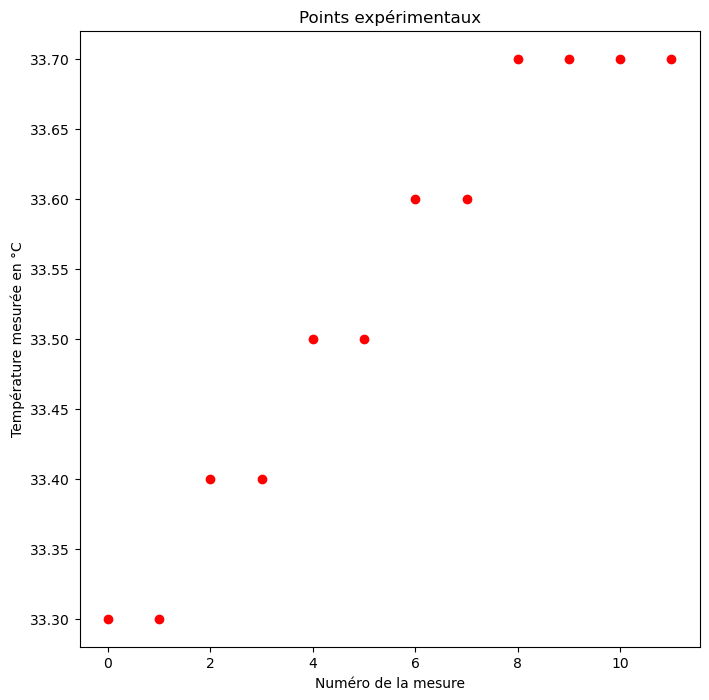

In [8]:
arduino = serial.Serial(port = 'COM3', baudrate=2000000, timeout=1)
sleep(1)

duree_acquisition = 60      # durée de l'acquisition en secondes
intervalle = 5      # intervalle entre 2 mesures en secondes

N = int(duree_acquisition / intervalle)    # nombre de points

liste_temperature = []      # liste contenant les mesures de température

for i in range(N):
    answer = arduino.readline().decode('ascii')  # température mesurée sous forme de string
    T = float(answer)       # température mesurée sous forme de float
    liste_temperature.append(T)
    sleep(intervalle)     # met l'acquisiton en pause pendant 20 secondes

print('Liste des températures mesurées :',liste_temperature)


import matplotlib.pyplot as plt    # Pour afficher des graphes

plt.figure(figsize=[8,8])
plt.plot(liste_temperature,'ro')
plt.xlabel('Numéro de la mesure')
plt.ylabel('Température mesurée en °C')
plt.title('Points expérimentaux')
plt.show()

arduino.close()

#### Bonus : acquision en temps réel

Il est possible de faire une acquisition en temps réel avec Python en utilisant la bibliothèque `Animation` du package `Matplotlib` (avec 5 secondes entre 2 mesures).

In [9]:
%matplotlib qt 
# affiche la figure dans une nouvelle fenêtre

In [12]:
from matplotlib.animation import FuncAnimation

dt = 5000

arduino = serial.Serial(port = 'COM3', baudrate=2000000, timeout=1)
sleep(1)

fig = plt.figure(figsize=(6, 3))
num_mesures = [1]
liste_T = [float(arduino.readline().decode('ascii'))]
 
plot, = plt.plot(num_mesures, liste_T, 'r-')

sleep(5)

def update(frame):
    num_mesures.append(num_mesures[-1] + 1)
    liste_T.append(float(arduino.readline().decode('ascii')))
 
    plot.set_data(num_mesures, liste_T) 
    fig.gca().relim()
    fig.gca().autoscale_view() 
    return plot,
 
animation = FuncAnimation(fig, update, interval=dt,cache_frame_data=False)
plt.show()


In [13]:
arduino.close()     

-----------------

## III- Conclusion :

Pour conclure, nous allons citer les notions du guide non abordées plus haut.

Si l'on travaille avec un appareil régulièrement (par exemple un oscilloscope dont les commandes sont fixes et non modifiables) il est préférable de définir une classe Python et d'implémenter les méthodes associées aux commandes. 

Le code ci-dessous prend en exemple un oscilloscope TDS210 Tekronik :

In [14]:
class TDS210:
    
    def __init(self, port_oscillo, baudrate_oscillo):
        self.oscillo = serial.Serial(port = port_oscillo, baudrate = baudrate_oscillo, timeout=1)
    
    def IDN(self):
        '''Méthode qui renvoie l IDN de l oscilloscope'''
        self.oscillo.write('*IDN?\n')   # commande pour renvoyer l'IDN
        self.IDN = self.oscillo.readline().decode('ascii')
        print('IDN :',self.IDN)  
        
    def change_baudrate(self, new_baudrate):
        '''Méthode qui change le baudrate de l oscilloscope'''
        self.oscillo.write(b'RS232:BAUD %i \n'%new_baudrate)   # on change le baudrate de l'oscilloscope
        self.oscillo.baurate = new_baudrate    # on change le baudrate de la communication avec l'oscilloscope
        
    def Auto_Set(self):
        '''Méthode qui demande à l oscilloscope de faire un AUTO SET'''
        self.oscillo.write('AUTOSET\n')   # commande pour faire un AUTOSET


Nous avons mis en exmple des méthodes simples, on peut penser à d'autres méthodes (modifier les Offset, les échelles horizontale et verticales, ...)

${} \;$

Pour finir, on peut citer le package `Pyvisa` qui est semblable à `Pyserial` (mais qui en dépend). Il offre un moyen "plus simple" de communiquer avec des appareils connectés en USB uniquement (oscilloscopes, GBFs ...) mais dont les fonctions et syntaxes sont similaires à `Pyserial`, il s'agit donc plus d'une "restriction" ou d'une "spécialisation" plutôt que d'une réelle alternative.

${} \;$

${} \;$

-----------

#### Crédits :

Ce Jupyter Notebook a été réalisé dans le cadre de mon stage court volontaire à l'INSP du 22/05/2023 au 16/06/2023 sous l'encadrement de Mr. Florent Margaillan.

Bradai Zakaria - L2 SPRINT 